In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.draw
import imgaug

# Root directory of the project
ROOT_DIR = os.path.abspath("")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "ca_pretrained_weights.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\tensorflow\

In [10]:
class AerialConfig(Config):
    """Configuration for training on the nucleus segmentation dataset."""
    # Give the configuration a recognizable name
    NAME = "aerial"

    # Adjust depending on your GPU memory
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + nucleus

    # Number of training and validation steps per epoc

    # Don't exclude based on confidence. Since we have two classes
    # then 0.5 is the minimum anyway as it picks between nucleus and BG
    DETECTION_MIN_CONFIDENCE = 0

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet50"

    # Input image resizing
    # Random crops of size 512x512
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    #IMAGE_MIN_SCALE = 2.0

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000
    
    STEPS_PER_EPOCH = 100

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.9

    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 64

    # Image mean (RGB)
    #MEAN_PIXEL = np.array([43.53, 39.56, 48.22])

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    #USE_MINI_MASK = True
    #MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 128

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 200

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 400

In [2]:
class AerialConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "aerial"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    
    TRAIN_ROIS_PER_IMAGE = 128
    
    
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + building

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.8

In [11]:
config = AerialConfig()

In [12]:

class AerialDataset(utils.Dataset):


    def load_aerial(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("aerial", 1, "building")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "document_train_val.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "aerial",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)    



    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "aerial":
            print("orinters")
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool) , np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "aerial":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [13]:
import json
dataset = ROOT_DIR + "\\datasets\\aerial\\middle_eastData\\buildings"
#datasets\aerial
# Training dataset.
dataset_train = AerialDataset()
dataset_train.load_aerial(dataset, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = AerialDataset()
dataset_val.load_aerial(dataset, "val")
dataset_val.prepare()

dataset_train.image_info

[{'id': '224336.jpg_342814',
  'source': 'aerial',
  'path': 'D:\\Hamzah\\JobPrep\\GPU_Projects\\MapDataset\\MatterPortGit\\Mask_RCNN_OG\\datasets\\aerial\\middle_eastData\\buildings\\train\\224336.jpg_342814',
  'width': 256,
  'height': 256,
  'polygons': [{'name': 'polygon',
    'all_points_x': [165, 155, 178, 178, 221, 250, 220],
    'all_points_y': [1, 17, 33, 37, 65, 17, 0]},
   {'name': 'polygon',
    'all_points_x': [243, 218, 237, 255, 255],
    'all_points_y': [36, 78, 90, 60, 42]},
   {'name': 'polygon',
    'all_points_x': [59, 23, 89, 128],
    'all_points_y': [88, 145, 190, 132]},
   {'name': 'polygon',
    'all_points_x': [142, 102, 117, 158],
    'all_points_y': [146, 212, 222, 154]},
   {'name': 'polygon',
    'all_points_x': [156, 128, 136, 127, 146, 141, 166, 173, 186, 214],
    'all_points_y': [173, 215, 220, 234, 246, 254, 256, 244, 253, 210]},
   {'name': 'polygon',
    'all_points_x': [217, 230, 255],
    'all_points_y': [255, 236, 254]},
   {'name': 'polygon',
 

194
<class 'numpy.ndarray'>
(256, 256, 7)
[1 1 1 1 1 1 1]


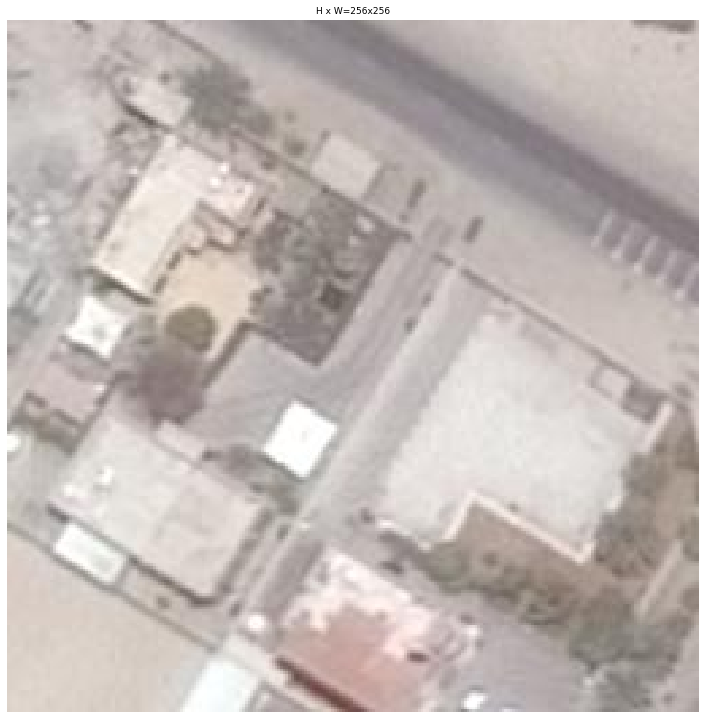

151
<class 'numpy.ndarray'>
(256, 256, 5)
[1 1 1 1 1]


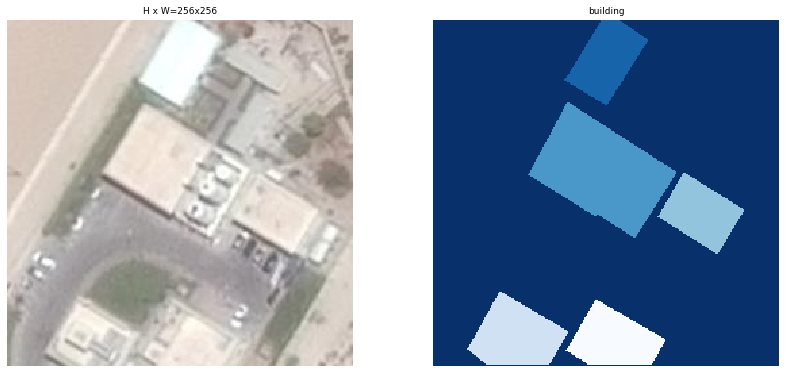

137
<class 'numpy.ndarray'>
(256, 256, 10)
[1 1 1 1 1 1 1 1 1 1]


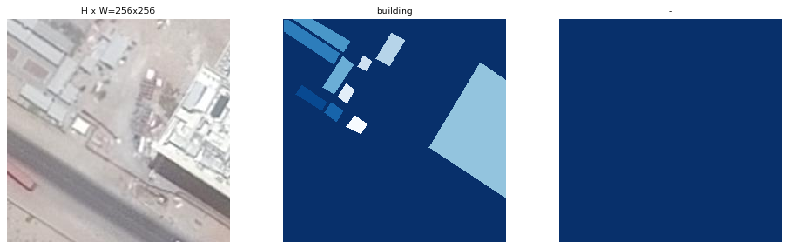

31
<class 'numpy.ndarray'>
(256, 256, 6)
[1 1 1 1 1 1]


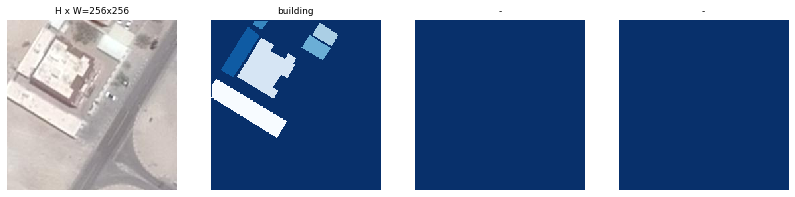

96
<class 'numpy.ndarray'>
(256, 256, 8)
[1 1 1 1 1 1 1 1]


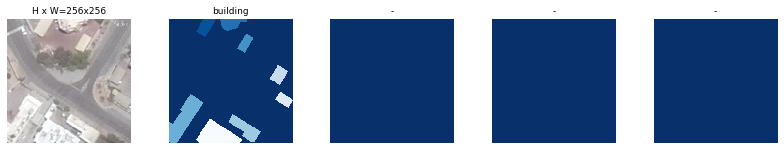

115
<class 'numpy.ndarray'>
(256, 256, 3)
[1 1 1]


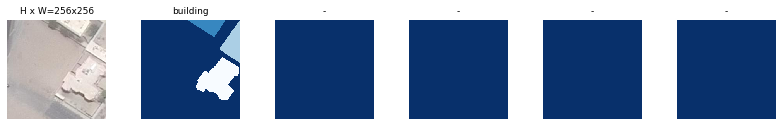

121
<class 'numpy.ndarray'>
(256, 256, 7)
[1 1 1 1 1 1 1]


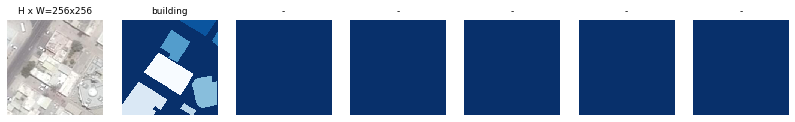

194
<class 'numpy.ndarray'>
(256, 256, 7)
[1 1 1 1 1 1 1]


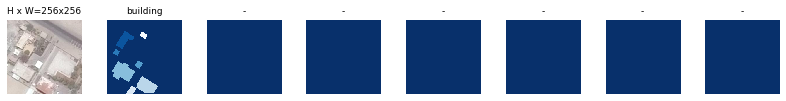

167
<class 'numpy.ndarray'>
(256, 256, 5)
[1 1 1 1 1]


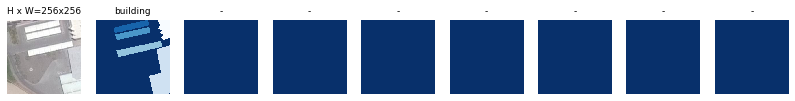

193
<class 'numpy.ndarray'>
(256, 256, 6)
[1 1 1 1 1 1]


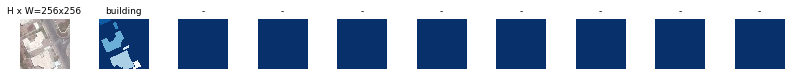

In [14]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 10)
counter = 0
for image_id in image_ids:
    print(image_id)
    image = dataset_train.load_image(image_id)
    print(type(image))
    mask, class_ids = dataset_train.load_mask(image_id)
    print(mask.shape)
    print(class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names,counter)
    counter += 1

In [15]:
config = AerialConfig()

# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)



#model = modellib.MaskRCNN(mode="training", config=config, model_dir=LOGS_DIRECTORY)
# Load pretrained weights
model_path = COCO_MODEL_PATH
model.load_weights(model_path, by_name=True)
#model.load_weights(model_path, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                #"mrcnn_bbox", "mrcnn_mask"])


In [16]:
'''
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=30, 
            layers='heads')

from keras.callbacks import EarlyStopping
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)


augmentation = imgaug.augmenters.Sometimes(0.5, [
                    imgaug.augmenters.Fliplr(0.5),
                    imgaug.augmenters.GaussianBlur(sigma=(0.0, 5.0))
                ])

'''



from imgaug import augmenters as iaa


# List of augmentations
# http://imgaug.readthedocs.io/en/latest/source/augmenters.html

augmentation = iaa.Sometimes(0.9, [
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Multiply((0.8, 1.2)),
    iaa.GaussianBlur(sigma=(0.0, 5.0))
])


#augmentation = imgaug.augmenters.Fliplr(0.5)
model.train(dataset_train, dataset_val,
                     learning_rate=config.LEARNING_RATE,
                     epochs=20,
                     layers='heads',
                     augmentation=augmentation)
#, custom_callbacks=[es]


Starting at epoch 0. LR=0.001

Checkpoint Path: D:\Hamzah\JobPrep\GPU_Projects\MapDataset\MatterPortGit\Mask_RCNN_OG\logs\aerial20200218T1905\mask_rcnn_aerial_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcn

C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
100/100 [==============================] - 234s 2s/step - loss: 2.4837 - rpn_class_loss: 0.2496 - rpn_bbox_loss: 0.9647 - mrcnn_class_loss: 0.4203 - mrcnn_bbox_loss: 0.3901 - mrcnn_mask_loss: 0.4590 - val_loss: 1.5868 - val_rpn_class_loss: 0.0779 - val_rpn_bbox_loss: 0.7269 - val_mrcnn_class_loss: 0.1386 - val_mrcnn_bbox_loss: 0.3074 - val_mrcnn_mask_loss: 0.3360
Epoch 2/20
100/100 [==============================] - 126s 1s/step - loss: 1.6429 - rpn_class_loss: 0.0794 - rpn_bbox_loss: 0.7441 - mrcnn_class_loss: 0.1570 - mrcnn_bbox_loss: 0.3198 - mrcnn_mask_loss: 0.3426 - val_loss: 1.5452 - val_rpn_class_loss: 0.0746 - val_rpn_bbox_loss: 0.6960 - val_mrcnn_class_loss: 0.1663 - val_mrcnn_bbox_loss: 0.2934 - val_mrcnn_mask_loss: 0.3149
Epoch 3/20
100/100 [==============================] - 126s 1s/step - loss: 1.5527 - rpn_class_loss: 0.0664 - rpn_bbox_loss: 0.7162 - mrcnn_class_loss: 0.1591 - mrcnn_bbox_loss: 0.2897 - mrcnn_mask_loss: 0.3212 - val_loss: 1.4487 - val_rpn_class_l

In [18]:
# Training - Stage 2
# Finetune layers from ResNet stage 4 and up
print("Fine tune Resnet stage 4 and up")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=20,
            layers='4+',
            augmentation=augmentation)


Fine tune Resnet stage 4 and up

Starting at epoch 20. LR=0.001

Checkpoint Path: D:\Hamzah\JobPrep\GPU_Projects\MapDataset\MatterPortGit\Mask_RCNN_OG\logs\aerial20200218T1905\mask_rcnn_aerial_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2

C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [19]:
# Training - Stage 3
# Fine tune all layers
print("Fine tune all layers")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=25,
            layers='all',
            augmentation=augmentation)

Fine tune all layers

Starting at epoch 20. LR=0.0001

Checkpoint Path: D:\Hamzah\JobPrep\GPU_Projects\MapDataset\MatterPortGit\Mask_RCNN_OG\logs\aerial20200218T1905\mask_rcnn_aerial_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_br

C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 21/25


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[256,256,14,14] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node mrcnn_mask_deconv_1/conv2d_transpose (defined at C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\keras\backend\tensorflow_backend.py:3242) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[mul_481/_8025]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[256,256,14,14] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node mrcnn_mask_deconv_1/conv2d_transpose (defined at C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\keras\backend\tensorflow_backend.py:3242) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

Errors may have originated from an input operation.
Input Source operations connected to node mrcnn_mask_deconv_1/conv2d_transpose:
 mrcnn_mask_deconv_1/kernel/read (defined at C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\keras\backend\tensorflow_backend.py:380)	
 mrcnn_mask_deconv_1/Reshape (defined at C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\keras\backend\tensorflow_backend.py:1776)	
 mrcnn_mask_deconv_1/stack (defined at C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\keras\backend\tensorflow_backend.py:3221)

Input Source operations connected to node mrcnn_mask_deconv_1/conv2d_transpose:
 mrcnn_mask_deconv_1/kernel/read (defined at C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\keras\backend\tensorflow_backend.py:380)	
 mrcnn_mask_deconv_1/Reshape (defined at C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\keras\backend\tensorflow_backend.py:1776)	
 mrcnn_mask_deconv_1/stack (defined at C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\keras\backend\tensorflow_backend.py:3221)

Original stack trace for 'mrcnn_mask_deconv_1/conv2d_transpose':
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\ipykernel\kernelapp.py", line 583, in start
    self.io_loop.start()
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\tornado\platform\asyncio.py", line 153, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\asyncio\base_events.py", line 538, in run_forever
    self._run_once()
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\asyncio\base_events.py", line 1782, in _run_once
    handle._run()
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\tornado\gen.py", line 787, in inner
    self.run()
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\ipykernel\kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\ipykernel\kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\ipykernel\ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\IPython\core\interactiveshell.py", line 2858, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\IPython\core\interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\IPython\core\interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\IPython\core\interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-51fd8cbb0873>", line 5, in <module>
    model_dir=MODEL_DIR)
  File "D:\Hamzah\JobPrep\GPU_Projects\MapDataset\MatterPortGit\Mask_RCNN_OG\mrcnn\model.py", line 1837, in __init__
    self.keras_model = self.build(mode=mode, config=config)
  File "D:\Hamzah\JobPrep\GPU_Projects\MapDataset\MatterPortGit\Mask_RCNN_OG\mrcnn\model.py", line 2004, in build
    train_bn=config.TRAIN_BN)
  File "D:\Hamzah\JobPrep\GPU_Projects\MapDataset\MatterPortGit\Mask_RCNN_OG\mrcnn\model.py", line 1002, in build_fpn_mask_graph
    name="mrcnn_mask_deconv")(x)
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\keras\engine\topology.py", line 603, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\keras\layers\wrappers.py", line 199, in call
    y = self.layer.call(inputs, **kwargs)
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\keras\layers\convolutional.py", line 774, in call
    data_format=self.data_format)
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\keras\backend\tensorflow_backend.py", line 3242, in conv2d_transpose
    data_format=tf_data_format)
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 2147, in conv2d_transpose
    name=name)
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 2218, in conv2d_transpose_v2
    name=name)
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 1407, in conv2d_backprop_input
    name=name)
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\tensorflow\python\framework\ops.py", line 3616, in create_op
    op_def=op_def)
  File "C:\Users\Hamzah\Anaconda3\envs\TF_GPU\lib\site-packages\tensorflow\python\framework\ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [14]:
%load_ext tensorboard
%tensorboard --logdir logs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 35976.